# Per-year performance, relative to the baseline (U-net<sub>2020</sub>)

In [16]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
proj_dir = os.path.dirname(os.getcwd())

train_counts_dic = np.load(os.path.join(proj_dir, 'analysis', 'SI_year_counts.npy'), allow_pickle=True).item()['train']
test_counts_dic = np.load(os.path.join(proj_dir, 'analysis', 'mylabels_year_counts_test.npy'), allow_pickle=True).item()

In [17]:
def is_rgb(year_str):
    return int(year_str) >= 1998
    
def compare_experiments(exp_name_list, color_list, task_list, epoch_list, short_name_list=None, task_name_list=None):

    
    if short_name_list is None:
        short_name_list = exp_name_list
    if task_name_list is None:
        task_name_list = task_list
    overall_score_dic = {t: [] for t in task_list}
    _, ax = plt.subplots(len(task_list) + 1, 1, figsize = (20, 4*(len(task_list)+1)))
    for i in range(len(exp_name_list)):
        exp_name = exp_name_list[i]
        color = color_list[i]
        short_name = short_name_list[i]
        exp_dir = os.path.join(proj_dir, 'output', exp_name, 'inference', 'epoch_{}'.format(epoch_list[i]), 'mylabels_test')
        metrics_fn = os.path.join(exp_dir, '{}_metrics.pt'.format(exp_name))
        report = torch.load(metrics_fn, map_location='cpu')
        try:
            spatial_metrics_dic = report['val_reports']['target_multitemp']
        except KeyError:
            spatial_metrics_dic = report['reports']['target_multitemp']
        
        for j, task in enumerate(task_list):
            years = list(spatial_metrics_dic[task].keys())
            for s in ['overall', 'overall_gray', 'overall_rgb']:
                if s in years:
                    years.remove(s)
            years = sorted(years)
            valid_items = [(y, 
                            spatial_metrics_dic[task][y]['F']['f1-score'],
                            spatial_metrics_dic[task][y]['F']['support'] + spatial_metrics_dic[task][y]['NF']['support']) \
                                                            for y in years if spatial_metrics_dic[task][y]['F']['support'] > 0]
        
            gray_items = [(y, value, counts) for y, value, counts in valid_items if not is_rgb(y)]
            gray_years, gray_values, gray_counts = zip(*gray_items)
            gray_years = np.array([int(y) for y in gray_years])
            rgb_items = [(y, value, counts) for y, value, counts in valid_items if is_rgb(y)]
            rgb_years, rgb_values, rgb_counts = zip(*rgb_items)
            rgb_years = np.array([int(y) for y in rgb_years])
            ticks_val = np.concatenate((gray_years, rgb_years))
            ticks_str = [str(y) for y in ticks_val]
            
            train_vals = [train_counts_dic[y] for y in ticks_str]
            test_vals = [test_counts_dic[y]['F'] for y in ticks_str]
            
            if i == 0:
                ref_gray_values = np.array(gray_values)
                ref_rgb_values = np.array(rgb_values)
                ref_values = np.array(gray_values + rgb_values)
            else:
                values = np.array(gray_values + rgb_values)
                ratio_values = values / ref_values
                
                width = 0.3  # the width of the bars
                offset = ((len(exp_name_list)-1) / 2) * width
                height = np.abs(ratio_values - 1)
                bottom = np.minimum(ratio_values, 1)
                ax[j].bar(x=ticks_val+width*i - offset, 
                                height=height, 
                                bottom=bottom, 
                                width=width, 
                                color=color, 
                                label=short_name)
                ax[j].set_title(task_name_list[j], pad=20)
                ax[j].set_ylabel('mean f-1 score ratio')
                
                ax[j].legend(loc='lower right')
                ax[j].set_xticks(ticks=ticks_val, labels=ticks_str, rotation=90, ha="right", size=12)
                ymin, ymax = 0.4, 1.8
                yticks = np.linspace(ymin, ymax, int((ymax-ymin)/0.2) + 2)
                ax[j].set_yticks(ticks=yticks, labels=yticks, minor=True)
                ax[j].set_yticks(ticks=[1], labels = [1], minor=False)
                ax[j].set_ylim((ymin, ymax))
                ax[j].yaxis.grid(True, which='major', linewidth=1.5)
                ax[j].yaxis.grid(True, which='minor', linestyle='--')            
            
            gray_overall_score = np.average(gray_values, weights=gray_counts)
            rgb_overall_score = np.average(rgb_values, weights=rgb_counts)
            overall_score = np.average([gray_overall_score, rgb_overall_score], weights=[np.sum(gray_counts), np.sum(rgb_counts)]) 
            overall_score_dic[task].append([short_name, gray_overall_score,rgb_overall_score, overall_score])
            
    width = 0.4
    offset = width/2
    red = np.array([234, 32, 39, int(255 * 1.0)]) / 255
    green = np.array([196, 229, 56, int(255 * 1.0)]) / 255
    ax[-1].bar(x=ticks_val - offset,
                        height=train_vals, width=width, label='train', color=green)
    ax2 = ax[-1].twinx()
    ax2.bar(x=ticks_val + offset, 
                        height=test_vals, width=width, label='test', color=red)
    ax2.set_ylabel('number of test F pixels')
    ax2.legend(loc='upper right')
    ax[-1].set_xticks(ticks=ticks_val, labels=ticks_str, rotation=90, ha="right", size=12)
    ax[-1].legend(loc='upper left')
    ax[-1].set_ylabel('number of training tiles')
    
            
    plt.tight_layout()
    plt.show()    
    

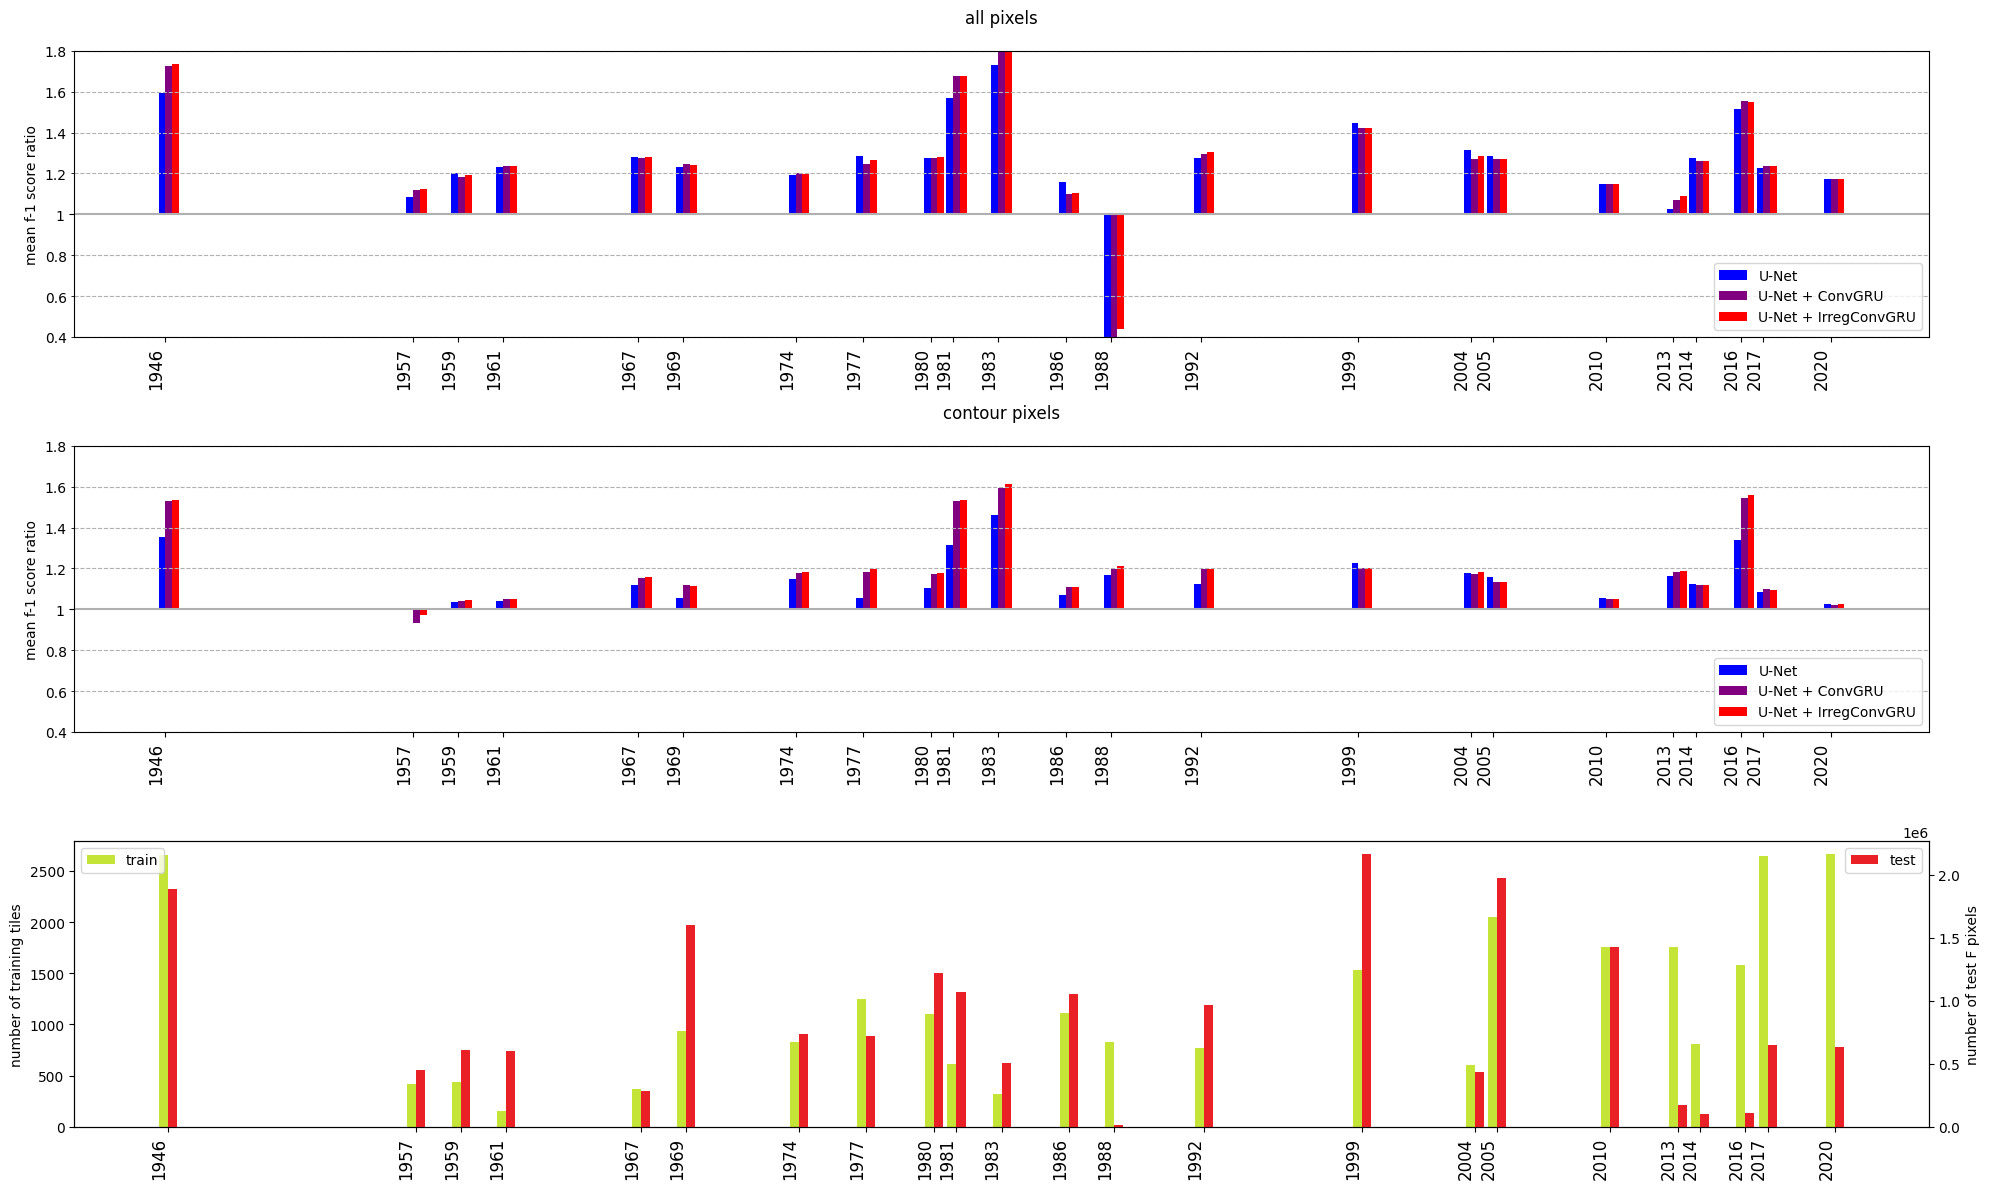

In [18]:
unet_exp_name = 'Unet_SI2020_100cm_grayaugment_rs4'
nr_exp_name = 'NRUnet7df_bwrd_freeze0_lrfe1em06_lrtemp0_0001_tlossCE_asymgraddot_ltemp1_0_1_0_rs2'
gru_exp_name = 'GRU7df_bwrd_freeze0_lrfe1em06_lrtemp0_0001_tlossCE_asymgraddot_ltemp1_0_1_0_rs0'
irreggru_exp_name = 'NIrregGRU7df_bwrd_freeze0_lrfe1em06_lrtemp0_0001_tlossCE_asymgraddot_ltemp1_0_1_0_rs1'
exp_name_list = [unet_exp_name, nr_exp_name, gru_exp_name, irreggru_exp_name]
exp_short_name_list = ['baseline','U-Net', 'U-Net + ConvGRU', 'U-Net + IrregConvGRU']
epoch_list = [19, 39, 39, 39]

task_list = ['seg', 'seg_contours']
task_name_list = ['all pixels', 'contour pixels']

compare_experiments(exp_name_list, 
                    ['g', 'b', 'purple', 'r'], 
                    task_list, 
                    epoch_list, 
                    short_name_list=exp_short_name_list,
                    task_name_list=task_name_list)

## Important note

Evaluation tiles are different for each acquisition year, so performances should not be compared across years, however models can be compared for a given acquisition year.